# MNIST - Sweeps

Runs a parameter sweep for determining best network architecture and for analyses.

In [1]:
from __future__ import absolute_import, division, print_function
import os, sys, pdb, pickle
from multiprocessing import Process, Pool, Queue
from itertools import product
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.datasets import mnist
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, Lambda, Activation
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.engine.topology import Layer
from keras import regularizers, activations
from keras import backend as K

from quantization_layers import *
from network_parameterization import *

#os.environ['CUDA_VISIBLE_DEVICES']=''

out_folder = 'sweeps'
if not os.path.exists(out_folder):
    os.makedirs(out_folder)

Using TensorFlow backend.


## Generate a range of network architectures

Sweeps over both the selection of layers and the individual hyperparameters for a given layer. Then filters for those whose memory falls in a certain range.

In [2]:
def hyperparams(x, Bc, Bf):
    result = []
    if x == 'C':
        for o in [4, 6, 8, 10, 12, 16, 32]:
            for k in [1, 3, 5]:
                result.append(('C', o, k, k, 1, 1, Bc, 8, 4))
            for k in [3, 5]:
                result.append(('DSC', o, k, k, 1, 1, Bc, 8, 4))
    if x == 'M':
        for k in [2]:
            result.append(('M', k, 4))
    if x == 'F':
        for o in [16, 32]:
            result.append(('F', o, Bf, 8, 4))
    if x == 'D':
        for d in [0.1]:
            result.append(('D', d, 4))
    return result

def combinate(l):
    result = []
    for Bc in [4]:
        for Bf in [4]:
            for input_dec in [2]:
                part = [[('A', input_dec, 4)] + list(x) + [('S', 10, Bf, 8, 16)] for x in product(*map(lambda x: hyperparams(x, Bc, Bf), l))]
                result += part
    return result
            
all_nns = []
for nl in range(2,4):
    for nc in range(nl + 1):
        #nc = nl
        nf = nl - nc
        for mp in range(nc + 1):
            layers = []
            for c in range(nc):
                layers.append('C')
                if mp == c:
                    layers.append('M')
            for f in range(nf):
                layers.append('F')
            layers.append('D')
            comb = combinate(layers)
            print(layers, '=>', len(comb))
            all_nns += comb
print('Total Number:', len(all_nns))
print('Representative:\n', all_nns[int(0.8*len(all_nns))])

['F', 'F', 'D'] => 4
['C', 'M', 'F', 'D'] => 70
['C', 'F', 'D'] => 70
['C', 'M', 'C', 'D'] => 1225
['C', 'C', 'M', 'D'] => 1225
['C', 'C', 'D'] => 1225
['F', 'F', 'F', 'D'] => 8
['C', 'M', 'F', 'F', 'D'] => 140
['C', 'F', 'F', 'D'] => 140
['C', 'M', 'C', 'F', 'D'] => 2450
['C', 'C', 'M', 'F', 'D'] => 2450
['C', 'C', 'F', 'D'] => 2450
['C', 'M', 'C', 'C', 'D'] => 42875
['C', 'C', 'M', 'C', 'D'] => 42875
['C', 'C', 'C', 'M', 'D'] => 42875
['C', 'C', 'C', 'D'] => 42875
Total Number: 182957
Representative:
 [('A', 2, 4), ('C', 6, 1, 1, 1, 1, 4, 8, 4), ('DSC', 4, 5, 5, 1, 1, 4, 8, 4), ('DSC', 10, 3, 3, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]


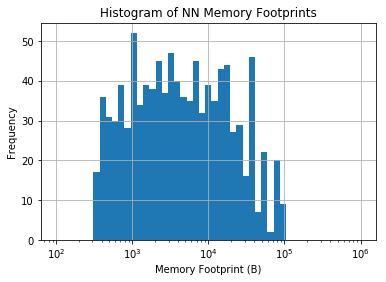

In [3]:
# Find the memory required for each architecture.
def get_mem(config):
    return sum(compute_storage(config, input_dimensions=[28,28,1], input_bits=8, streaming='true', convolution_strategy='herringbone'))
mem_correspondence, all_nns = map(list, zip(*filter(lambda x: x[0] > 0, [(get_mem(nn), nn) for nn in all_nns])))

# Sample uniformly in log-domain.
np.random.seed(0)
fs, xs = np.histogram(mem_correspondence, bins=np.logspace(np.log10(min(mem_correspondence)), np.log10(max(mem_correspondence)), 50))
fs = fs + 0.1
inv_sampling_weights = 1.0 / np.interp(mem_correspondence, (xs[:-1] + xs[1:])/2.0, fs)
inv_sampling_weights /= sum(inv_sampling_weights)
arch_idx_use = np.random.choice(range(len(mem_correspondence)), size=1000, replace=False, p=inv_sampling_weights)

# View a histogram of sampled architectures.
arch_mem_use = [mem_correspondence[i] for i in arch_idx_use]
arch_use = [all_nns[i] for i in arch_idx_use]
plt.hist(arch_mem_use, bins=np.logspace(np.log10(100),np.log10(1000000), 50))
plt.xscale('log')
plt.xlabel('Memory Footprint (B)')
plt.ylabel('Frequency')
plt.title('Histogram of NN Memory Footprints')
plt.grid()
plt.show()

In [4]:
all_nns = arch_use
np.random.seed(0)
np.random.shuffle(all_nns)

## Run the sweeps

Trains each potential network with 5 epochs of floating point training and 5 epochs of quantized training.

In [6]:
batch_size = 128
num_classes = 10

# Grab and massage the training and test data.
(x_train, y_train), (x_test, y_test) = mnist.load_data()
img_rows, img_cols = x_train.shape[1:3]

x_train = x_train.astype('float32') / 256
x_test  = x_test.astype('float32') / 256
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test  = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

np.random.seed(0)
val_set = np.zeros(x_train.shape[0], dtype='bool')
val_set[np.random.choice(x_train.shape[0], 10000, replace=False)] = 1
x_val = x_train[val_set]
y_val = y_train[val_set]
x_train = x_train[~val_set]
y_train = y_train[~val_set]

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'val samples')
print(x_test.shape[0], 'test samples')

def run_config(config):
    lrate95 = LearningRateScheduler(lambda epoch: max(1e-4, 0.005 * 0.95**epoch))

    X_input = Input(shape=x_train.shape[1:])
    X = output_logits(X_input, config, fp=True)
    X = Activation('softmax')(X)
    modelF = Model(X_input, X)
    modelF.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
    histf = modelF.fit(x_train, y_train, batch_size=batch_size, epochs=5, callbacks=[lrate95], verbose=0, validation_data=(x_val, y_val))
    fa = max(histf.history['val_acc'])

    X_input = Input(shape=x_train.shape[1:])
    X = output_logits(X_input, config, fp=False, qt=True)
    X = Activation('softmax')(X)
    model = Model(X_input, X)
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
    loadQ(modelF, model, x_val)
    histq = model.fit(x_train, y_train, batch_size=batch_size, epochs=5, callbacks=[lrate95], verbose=0, validation_data=(x_val, y_val))
    qa = max(histq.history['val_acc'])
    K.clear_session()
    return (fa, qa)

def start_task(gpu_id, iq, oq):
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
    while True:
        nn = iq.get()
        try:
            fa, qa = run_config(nn)
        except Exception as e:
            print('Error: %s - %s'%(e, nn))
            fa, qa = -1, -1
        oq.put((nn, fa, qa))
            
GPUS = 4
if __name__ == '__main__':
    processes = []
    input_queue = Queue() # https://pymotw.com/2/multiprocessing/communication.html
    output_queue = Queue()
    
    for gpu_id in range(GPUS):
        p = Process(target=start_task, args=(gpu_id, input_queue, output_queue))
        p.start()
        processes.append(p)
        
    for nn in all_nns:
        input_queue.put(nn)
    
    idx = 0
    all_nns_used = []
    all_vas = []
    while not input_queue.empty():
        idx += 1
        nn, fa, qa = output_queue.get()
        all_nns_used.append(nn)
        all_vas.append((fa, qa))
        storage = sum(compute_storage(nn))
        print('%05d/%05d - %05dB - F%05.2f%% - Q%05.2f%% - Network:'%(
            idx, len(all_nns), storage, 100*fa, 100*qa), nn)
        with open('%s/log-uniform-%05d.p'%(out_folder, len(all_nns)), 'wb') as f:
            pickle.dump((all_nns_used, all_vas), f)
    for p in processes: p.terminate()

x_train shape: (50000, 28, 28, 1)
50000 train samples
10000 val samples
10000 test samples
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for 

00023/01000 - 00472B - F88.94% - Q86.47% - Network: [('A', 2, 4), ('C', 4, 3, 3, 1, 1, 4, 8, 4), ('M', 2, 4), ('DSC', 4, 3, 3, 1, 1, 4, 8, 4), ('DSC', 4, 3, 3, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00024/01000 - 02506B - F97.21% - Q97.41% - Network: [('A', 2, 4), ('C', 12, 1, 1, 1, 1, 4, 8, 4), ('DSC', 16, 3, 3, 1, 1, 4, 8, 4), ('C', 4, 5, 5, 1, 1, 4, 8, 4), ('M', 2, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00025/01000 - 00367B - F84.41% - Q77.57% - Network: [('A', 2, 4), ('DSC', 4, 5, 5, 1, 1, 4, 8, 4), ('M', 2, 4), ('DSC', 8, 5, 5, 1, 1, 4, 8, 4), ('C', 6, 1, 1, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00026/01000 - 52142B - F95.59% - Q96.12% - Network: [('A', 2, 4), ('C', 16, 1, 1, 1, 1, 4, 8, 4), ('C', 16, 1, 1, 1, 1, 4, 8, 4), ('F', 32, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00027/01000 - 06109B - F98.17% - Q98.35% - Network: [('A', 2, 4), ('C', 10, 5, 5, 1, 1, 4, 8, 4), ('C', 10, 5, 5, 1, 1, 4, 8, 4), ('C', 32, 5, 5, 1, 1, 4, 8, 4), ('M', 2, 4), ('D

00064/01000 - 01695B - F96.50% - Q96.11% - Network: [('A', 2, 4), ('DSC', 10, 5, 5, 1, 1, 4, 8, 4), ('C', 16, 1, 1, 1, 1, 4, 8, 4), ('DSC', 10, 5, 5, 1, 1, 4, 8, 4), ('M', 2, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00065/01000 - 01755B - F95.62% - Q93.41% - Network: [('A', 2, 4), ('DSC', 16, 3, 3, 1, 1, 4, 8, 4), ('DSC', 16, 5, 5, 1, 1, 4, 8, 4), ('M', 2, 4), ('DSC', 4, 3, 3, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00066/01000 - 00425B - F90.72% - Q79.99% - Network: [('A', 2, 4), ('C', 4, 5, 5, 1, 1, 4, 8, 4), ('DSC', 4, 3, 3, 1, 1, 4, 8, 4), ('M', 2, 4), ('DSC', 4, 3, 3, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00067/01000 - 08724B - F97.72% - Q97.72% - Network: [('A', 2, 4), ('C', 32, 1, 1, 1, 1, 4, 8, 4), ('DSC', 4, 5, 5, 1, 1, 4, 8, 4), ('C', 10, 1, 1, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00068/01000 - 00379B - F83.95% - Q77.72% - Network: [('A', 2, 4), ('DSC', 4, 5, 5, 1, 1, 4, 8, 4), ('M', 2, 4), ('DSC', 12, 5, 5, 1, 1, 4, 8, 4), ('D', 0.1, 4

00104/01000 - 00669B - F93.34% - Q92.97% - Network: [('A', 2, 4), ('DSC', 6, 5, 5, 1, 1, 4, 8, 4), ('DSC', 12, 5, 5, 1, 1, 4, 8, 4), ('M', 2, 4), ('C', 4, 1, 1, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00105/01000 - 01651B - F95.23% - Q94.15% - Network: [('A', 2, 4), ('DSC', 4, 3, 3, 1, 1, 4, 8, 4), ('M', 2, 4), ('C', 10, 5, 5, 1, 1, 4, 8, 4), ('F', 32, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00106/01000 - 24392B - F98.66% - Q98.73% - Network: [('A', 2, 4), ('C', 10, 1, 1, 1, 1, 4, 8, 4), ('C', 32, 5, 5, 1, 1, 4, 8, 4), ('C', 32, 5, 5, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00107/01000 - 01610B - F97.12% - Q97.29% - Network: [('A', 2, 4), ('C', 12, 5, 5, 1, 1, 4, 8, 4), ('C', 16, 1, 1, 1, 1, 4, 8, 4), ('M', 2, 4), ('DSC', 8, 3, 3, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00108/01000 - 00702B - F87.77% - Q72.32% - Network: [('A', 2, 4), ('DSC', 6, 3, 3, 1, 1, 4, 8, 4), ('DSC', 6, 3, 3, 1, 1, 4, 8, 4), ('M', 2, 4), ('DSC', 12, 5, 5, 1, 1, 4, 8, 4)

00145/01000 - 11330B - F98.21% - Q98.18% - Network: [('A', 2, 4), ('C', 32, 3, 3, 1, 1, 4, 8, 4), ('C', 8, 1, 1, 1, 1, 4, 8, 4), ('C', 12, 1, 1, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00146/01000 - 02567B - F96.04% - Q95.66% - Network: [('A', 2, 4), ('DSC', 6, 5, 5, 1, 1, 4, 8, 4), ('C', 32, 1, 1, 1, 1, 4, 8, 4), ('DSC', 6, 5, 5, 1, 1, 4, 8, 4), ('M', 2, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00147/01000 - 04129B - F97.39% - Q96.61% - Network: [('A', 2, 4), ('DSC', 16, 5, 5, 1, 1, 4, 8, 4), ('DSC', 10, 5, 5, 1, 1, 4, 8, 4), ('C', 16, 1, 1, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00148/01000 - 00443B - F91.22% - Q85.43% - Network: [('A', 2, 4), ('DSC', 4, 5, 5, 1, 1, 4, 8, 4), ('M', 2, 4), ('DSC', 4, 3, 3, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00149/01000 - 41110B - F98.13% - Q98.08% - Network: [('A', 2, 4), ('C', 12, 1, 1, 1, 1, 4, 8, 4), ('C', 32, 3, 3, 1, 1, 4, 8, 4), ('F', 16, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00150/01000 - 01022B 

00185/01000 - 14853B - F97.74% - Q97.40% - Network: [('A', 2, 4), ('DSC', 10, 3, 3, 1, 1, 4, 8, 4), ('DSC', 32, 5, 5, 1, 1, 4, 8, 4), ('C', 32, 5, 5, 1, 1, 4, 8, 4), ('M', 2, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00186/01000 - 12062B - F98.25% - Q98.28% - Network: [('A', 2, 4), ('C', 32, 1, 1, 1, 1, 4, 8, 4), ('C', 12, 5, 5, 1, 1, 4, 8, 4), ('C', 8, 1, 1, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00187/01000 - 15450B - F98.60% - Q98.77% - Network: [('A', 2, 4), ('C', 32, 1, 1, 1, 1, 4, 8, 4), ('DSC', 32, 3, 3, 1, 1, 4, 8, 4), ('C', 16, 5, 5, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00188/01000 - 01553B - F95.51% - Q93.45% - Network: [('A', 2, 4), ('DSC', 10, 3, 3, 1, 1, 4, 8, 4), ('M', 2, 4), ('C', 10, 1, 1, 1, 1, 4, 8, 4), ('DSC', 8, 3, 3, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00189/01000 - 02157B - F96.98% - Q97.06% - Network: [('A', 2, 4), ('DSC', 16, 5, 5, 1, 1, 4, 8, 4), ('DSC', 6, 3, 3, 1, 1, 4, 8, 4), ('C', 16, 3, 3, 1, 1, 4, 8, 4), ('M', 2, 

00223/01000 - 00561B - F90.73% - Q87.51% - Network: [('A', 2, 4), ('DSC', 6, 5, 5, 1, 1, 4, 8, 4), ('M', 2, 4), ('DSC', 4, 3, 3, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00224/01000 - 17955B - F98.13% - Q98.27% - Network: [('A', 2, 4), ('C', 6, 5, 5, 1, 1, 4, 8, 4), ('C', 10, 1, 1, 1, 1, 4, 8, 4), ('C', 32, 1, 1, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00225/01000 - 03372B - F98.21% - Q98.34% - Network: [('A', 2, 4), ('C', 6, 1, 1, 1, 1, 4, 8, 4), ('C', 8, 5, 5, 1, 1, 4, 8, 4), ('C', 6, 3, 3, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00226/01000 - 39472B - F96.27% - Q95.80% - Network: [('A', 2, 4), ('DSC', 8, 3, 3, 1, 1, 4, 8, 4), ('C', 32, 1, 1, 1, 1, 4, 8, 4), ('F', 16, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00227/01000 - 17433B - F93.34% - Q93.64% - Network: [('A', 2, 4), ('C', 10, 1, 1, 1, 1, 4, 8, 4), ('C', 8, 1, 1, 1, 1, 4, 8, 4), ('C', 16, 1, 1, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00228/01000 - 00580B - F94.08% - Q91.18% - 

00263/01000 - 00659B - F93.16% - Q90.72% - Network: [('A', 2, 4), ('DSC', 4, 5, 5, 1, 1, 4, 8, 4), ('DSC', 12, 5, 5, 1, 1, 4, 8, 4), ('DSC', 6, 5, 5, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00264/01000 - 00823B - F95.13% - Q94.23% - Network: [('A', 2, 4), ('C', 4, 5, 5, 1, 1, 4, 8, 4), ('DSC', 4, 5, 5, 1, 1, 4, 8, 4), ('M', 2, 4), ('C', 10, 1, 1, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00265/01000 - 03612B - F95.98% - Q94.82% - Network: [('A', 2, 4), ('DSC', 32, 3, 3, 1, 1, 4, 8, 4), ('C', 6, 3, 3, 1, 1, 4, 8, 4), ('DSC', 6, 5, 5, 1, 1, 4, 8, 4), ('M', 2, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00266/01000 - 17856B - F97.10% - Q96.15% - Network: [('A', 2, 4), ('DSC', 6, 5, 5, 1, 1, 4, 8, 4), ('C', 8, 1, 1, 1, 1, 4, 8, 4), ('C', 32, 1, 1, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00267/01000 - 00493B - F90.22% - Q86.30% - Network: [('A', 2, 4), ('C', 4, 5, 5, 1, 1, 4, 8, 4), ('DSC', 4, 5, 5, 1, 1, 4, 8, 4), ('DSC', 12, 5, 5, 1, 1, 4, 8, 4), ('M', 2, 4),

00303/01000 - 53635B - F97.29% - Q96.26% - Network: [('A', 2, 4), ('DSC', 32, 5, 5, 1, 1, 4, 8, 4), ('C', 32, 1, 1, 1, 1, 4, 8, 4), ('F', 32, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00304/01000 - 02127B - F97.90% - Q97.77% - Network: [('A', 2, 4), ('C', 10, 3, 3, 1, 1, 4, 8, 4), ('M', 2, 4), ('C', 32, 1, 1, 1, 1, 4, 8, 4), ('DSC', 10, 3, 3, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00305/01000 - 10423B - F97.85% - Q97.83% - Network: [('A', 2, 4), ('DSC', 32, 3, 3, 1, 1, 4, 8, 4), ('C', 16, 5, 5, 1, 1, 4, 8, 4), ('DSC', 16, 5, 5, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00306/01000 - 11310B - F91.90% - Q91.92% - Network: [('A', 2, 4), ('C', 16, 1, 1, 1, 1, 4, 8, 4), ('M', 2, 4), ('C', 12, 1, 1, 1, 1, 4, 8, 4), ('F', 32, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00307/01000 - 02512B - F95.53% - Q95.23% - Network: [('A', 2, 4), ('C', 6, 5, 5, 1, 1, 4, 8, 4), ('C', 16, 5, 5, 1, 1, 4, 8, 4), ('C', 4, 5, 5, 1, 1, 4, 8, 4), ('M', 2, 4), ('D', 0.1, 4), ('S', 10, 

00343/01000 - 04888B - F97.98% - Q97.35% - Network: [('A', 2, 4), ('C', 32, 3, 3, 1, 1, 4, 8, 4), ('C', 4, 5, 5, 1, 1, 4, 8, 4), ('DSC', 16, 3, 3, 1, 1, 4, 8, 4), ('M', 2, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00344/01000 - 05022B - F98.41% - Q98.56% - Network: [('A', 2, 4), ('C', 32, 3, 3, 1, 1, 4, 8, 4), ('DSC', 32, 5, 5, 1, 1, 4, 8, 4), ('M', 2, 4), ('C', 16, 1, 1, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00345/01000 - 06634B - F98.13% - Q98.26% - Network: [('A', 2, 4), ('C', 6, 1, 1, 1, 1, 4, 8, 4), ('C', 12, 5, 5, 1, 1, 4, 8, 4), ('M', 2, 4), ('F', 32, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00346/01000 - 01812B - F97.65% - Q96.91% - Network: [('A', 2, 4), ('C', 4, 3, 3, 1, 1, 4, 8, 4), ('DSC', 10, 5, 5, 1, 1, 4, 8, 4), ('M', 2, 4), ('C', 16, 1, 1, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00347/01000 - 67418B - F98.49% - Q98.55% - Network: [('A', 2, 4), ('C', 32, 1, 1, 1, 1, 4, 8, 4), ('C', 32, 5, 5, 1, 1, 4, 8, 4), ('F', 32, 4, 8, 4), ('D', 0.1, 4), 

00384/01000 - 09129B - F98.21% - Q97.77% - Network: [('A', 2, 4), ('DSC', 12, 3, 3, 1, 1, 4, 8, 4), ('DSC', 10, 3, 3, 1, 1, 4, 8, 4), ('C', 16, 1, 1, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00385/01000 - 26110B - F98.72% - Q98.81% - Network: [('A', 2, 4), ('C', 32, 3, 3, 1, 1, 4, 8, 4), ('C', 32, 5, 5, 1, 1, 4, 8, 4), ('C', 32, 1, 1, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00386/01000 - 02242B - F95.52% - Q95.21% - Network: [('A', 2, 4), ('C', 12, 1, 1, 1, 1, 4, 8, 4), ('C', 12, 3, 3, 1, 1, 4, 8, 4), ('M', 2, 4), ('DSC', 8, 5, 5, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00387/01000 - 01487B - F94.98% - Q90.89% - Network: [('A', 2, 4), ('DSC', 8, 5, 5, 1, 1, 4, 8, 4), ('DSC', 32, 5, 5, 1, 1, 4, 8, 4), ('DSC', 8, 5, 5, 1, 1, 4, 8, 4), ('M', 2, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00388/01000 - 17924B - F97.84% - Q97.88% - Network: [('A', 2, 4), ('C', 4, 1, 1, 1, 1, 4, 8, 4), ('DSC', 10, 5, 5, 1, 1, 4, 8, 4), ('C', 32, 1, 1, 1, 1, 4, 8, 4), ('D', 0.1,

00423/01000 - 15798B - F98.18% - Q98.28% - Network: [('A', 2, 4), ('C', 32, 1, 1, 1, 1, 4, 8, 4), ('C', 12, 1, 1, 1, 1, 4, 8, 4), ('C', 16, 3, 3, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00424/01000 - 24588B - F98.02% - Q98.13% - Network: [('A', 2, 4), ('C', 10, 3, 3, 1, 1, 4, 8, 4), ('F', 32, 4, 8, 4), ('F', 32, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00425/01000 - 103856B - F95.55% - Q95.67% - Network: [('A', 2, 4), ('C', 6, 1, 1, 1, 1, 4, 8, 4), ('C', 32, 1, 1, 1, 1, 4, 8, 4), ('F', 32, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00426/01000 - 00903B - F71.35% - Q67.38% - Network: [('A', 2, 4), ('DSC', 4, 3, 3, 1, 1, 4, 8, 4), ('M', 2, 4), ('DSC', 32, 5, 5, 1, 1, 4, 8, 4), ('C', 12, 1, 1, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00427/01000 - 06268B - F98.11% - Q98.12% - Network: [('A', 2, 4), ('C', 32, 5, 5, 1, 1, 4, 8, 4), ('C', 10, 5, 5, 1, 1, 4, 8, 4), ('M', 2, 4), ('C', 4, 1, 1, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00428/01000 - 0276

00464/01000 - 04558B - F98.07% - Q97.81% - Network: [('A', 2, 4), ('DSC', 12, 3, 3, 1, 1, 4, 8, 4), ('C', 10, 3, 3, 1, 1, 4, 8, 4), ('DSC', 16, 5, 5, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00465/01000 - 03781B - F98.29% - Q98.04% - Network: [('A', 2, 4), ('DSC', 6, 3, 3, 1, 1, 4, 8, 4), ('C', 12, 5, 5, 1, 1, 4, 8, 4), ('C', 10, 3, 3, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00466/01000 - 01157B - F97.10% - Q96.23% - Network: [('A', 2, 4), ('C', 4, 5, 5, 1, 1, 4, 8, 4), ('DSC', 6, 3, 3, 1, 1, 4, 8, 4), ('M', 2, 4), ('C', 10, 1, 1, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00467/01000 - 01033B - F96.08% - Q95.53% - Network: [('A', 2, 4), ('C', 8, 3, 3, 1, 1, 4, 8, 4), ('C', 6, 1, 1, 1, 1, 4, 8, 4), ('M', 2, 4), ('DSC', 4, 3, 3, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00468/01000 - 11212B - F98.61% - Q98.59% - Network: [('A', 2, 4), ('C', 16, 1, 1, 1, 1, 4, 8, 4), ('C', 32, 3, 3, 1, 1, 4, 8, 4), ('C', 10, 3, 3, 1, 1, 4, 8, 4), ('D', 0.1, 4), (

00504/01000 - 07817B - F98.12% - Q97.93% - Network: [('A', 2, 4), ('DSC', 32, 3, 3, 1, 1, 4, 8, 4), ('C', 16, 1, 1, 1, 1, 4, 8, 4), ('DSC', 10, 3, 3, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00505/01000 - 07576B - F98.44% - Q98.43% - Network: [('A', 2, 4), ('C', 32, 5, 5, 1, 1, 4, 8, 4), ('C', 10, 5, 5, 1, 1, 4, 8, 4), ('C', 12, 3, 3, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00506/01000 - 33127B - F98.00% - Q97.95% - Network: [('A', 2, 4), ('DSC', 32, 5, 5, 1, 1, 4, 8, 4), ('C', 32, 5, 5, 1, 1, 4, 8, 4), ('F', 32, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00507/01000 - 39603B - F97.37% - Q97.37% - Network: [('A', 2, 4), ('C', 12, 1, 1, 1, 1, 4, 8, 4), ('DSC', 32, 3, 3, 1, 1, 4, 8, 4), ('F', 16, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00508/01000 - 76440B - F97.35% - Q97.02% - Network: [('A', 2, 4), ('DSC', 8, 3, 3, 1, 1, 4, 8, 4), ('C', 32, 1, 1, 1, 1, 4, 8, 4), ('F', 32, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00509/01000 - 12662B - F98.25% - Q98.

00544/01000 - 34883B - F93.30% - Q93.65% - Network: [('A', 2, 4), ('C', 32, 1, 1, 1, 1, 4, 8, 4), ('C', 8, 1, 1, 1, 1, 4, 8, 4), ('C', 32, 1, 1, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00545/01000 - 07048B - F98.05% - Q98.11% - Network: [('A', 2, 4), ('C', 6, 3, 3, 1, 1, 4, 8, 4), ('DSC', 16, 3, 3, 1, 1, 4, 8, 4), ('C', 12, 1, 1, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00546/01000 - 57192B - F98.37% - Q98.59% - Network: [('A', 2, 4), ('C', 10, 1, 1, 1, 1, 4, 8, 4), ('C', 32, 5, 5, 1, 1, 4, 8, 4), ('F', 32, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00547/01000 - 01035B - F90.37% - Q88.35% - Network: [('A', 2, 4), ('DSC', 4, 3, 3, 1, 1, 4, 8, 4), ('M', 2, 4), ('DSC', 8, 3, 3, 1, 1, 4, 8, 4), ('C', 8, 1, 1, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00548/01000 - 76424B - F98.28% - Q98.14% - Network: [('A', 2, 4), ('C', 6, 3, 3, 1, 1, 4, 8, 4), ('C', 32, 1, 1, 1, 1, 4, 8, 4), ('F', 32, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00549/01000 - 01286B 

00584/01000 - 01581B - F95.21% - Q93.20% - Network: [('A', 2, 4), ('DSC', 6, 3, 3, 1, 1, 4, 8, 4), ('M', 2, 4), ('DSC', 12, 3, 3, 1, 1, 4, 8, 4), ('C', 12, 1, 1, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00585/01000 - 03895B - F97.27% - Q96.86% - Network: [('A', 2, 4), ('DSC', 16, 3, 3, 1, 1, 4, 8, 4), ('DSC', 16, 3, 3, 1, 1, 4, 8, 4), ('M', 2, 4), ('C', 12, 5, 5, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00586/01000 - 00552B - F87.33% - Q10.01% - Network: [('A', 2, 4), ('DSC', 4, 3, 3, 1, 1, 4, 8, 4), ('M', 2, 4), ('C', 6, 3, 3, 1, 1, 4, 8, 4), ('DSC', 4, 3, 3, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
Error: cannot do a non-empty take from an empty axes. - [('A', 2, 4), ('DSC', 4, 5, 5, 1, 1, 4, 8, 4), ('M', 2, 4), ('DSC', 12, 3, 3, 1, 1, 4, 8, 4), ('DSC', 4, 3, 3, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00587/01000 - 00401B - F-100.00% - Q-100.00% - Network: [('A', 2, 4), ('DSC', 4, 5, 5, 1, 1, 4, 8, 4), ('M', 2, 4), ('DSC', 12, 3, 3, 1, 1, 

00624/01000 - 04368B - F97.35% - Q96.91% - Network: [('A', 2, 4), ('DSC', 16, 3, 3, 1, 1, 4, 8, 4), ('C', 10, 5, 5, 1, 1, 4, 8, 4), ('DSC', 12, 5, 5, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00625/01000 - 19330B - F98.57% - Q98.58% - Network: [('A', 2, 4), ('C', 12, 3, 3, 1, 1, 4, 8, 4), ('C', 32, 1, 1, 1, 1, 4, 8, 4), ('DSC', 32, 3, 3, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00626/01000 - 00971B - F95.29% - Q93.60% - Network: [('A', 2, 4), ('DSC', 6, 5, 5, 1, 1, 4, 8, 4), ('DSC', 10, 3, 3, 1, 1, 4, 8, 4), ('C', 6, 3, 3, 1, 1, 4, 8, 4), ('M', 2, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00627/01000 - 27830B - F98.42% - Q98.41% - Network: [('A', 2, 4), ('C', 16, 5, 5, 1, 1, 4, 8, 4), ('C', 32, 1, 1, 1, 1, 4, 8, 4), ('F', 16, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00628/01000 - 01950B - F92.97% - Q92.22% - Network: [('A', 2, 4), ('C', 4, 1, 1, 1, 1, 4, 8, 4), ('C', 12, 1, 1, 1, 1, 4, 8, 4), ('M', 2, 4), ('C', 4, 3, 3, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4

00665/01000 - 00547B - F90.96% - Q86.25% - Network: [('A', 2, 4), ('DSC', 4, 3, 3, 1, 1, 4, 8, 4), ('M', 2, 4), ('DSC', 8, 5, 5, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00666/01000 - 10150B - F98.30% - Q98.34% - Network: [('A', 2, 4), ('C', 32, 3, 3, 1, 1, 4, 8, 4), ('C', 8, 3, 3, 1, 1, 4, 8, 4), ('F', 16, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00667/01000 - 01720B - F92.93% - Q94.82% - Network: [('A', 2, 4), ('C', 12, 5, 5, 1, 1, 4, 8, 4), ('M', 2, 4), ('C', 6, 5, 5, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00668/01000 - 00391B - F78.33% - Q64.75% - Network: [('A', 2, 4), ('DSC', 4, 5, 5, 1, 1, 4, 8, 4), ('DSC', 4, 5, 5, 1, 1, 4, 8, 4), ('M', 2, 4), ('C', 4, 3, 3, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00669/01000 - 14495B - F94.29% - Q94.28% - Network: [('A', 2, 4), ('C', 6, 1, 1, 1, 1, 4, 8, 4), ('M', 2, 4), ('C', 32, 3, 3, 1, 1, 4, 8, 4), ('C', 32, 5, 5, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00670/01000 - 05442B - F97.93% - Q

00705/01000 - 03678B - F98.22% - Q98.27% - Network: [('A', 2, 4), ('C', 32, 5, 5, 1, 1, 4, 8, 4), ('DSC', 8, 3, 3, 1, 1, 4, 8, 4), ('C', 16, 3, 3, 1, 1, 4, 8, 4), ('M', 2, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00706/01000 - 01057B - F95.44% - Q95.33% - Network: [('A', 2, 4), ('DSC', 4, 5, 5, 1, 1, 4, 8, 4), ('C', 4, 5, 5, 1, 1, 4, 8, 4), ('C', 16, 3, 3, 1, 1, 4, 8, 4), ('M', 2, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00707/01000 - 03106B - F97.51% - Q97.36% - Network: [('A', 2, 4), ('C', 16, 3, 3, 1, 1, 4, 8, 4), ('C', 8, 5, 5, 1, 1, 4, 8, 4), ('DSC', 4, 3, 3, 1, 1, 4, 8, 4), ('M', 2, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00708/01000 - 01132B - F97.08% - Q96.96% - Network: [('A', 2, 4), ('C', 10, 5, 5, 1, 1, 4, 8, 4), ('DSC', 12, 3, 3, 1, 1, 4, 8, 4), ('M', 2, 4), ('C', 4, 1, 1, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00709/01000 - 07582B - F97.28% - Q97.61% - Network: [('A', 2, 4), ('C', 16, 1, 1, 1, 1, 4, 8, 4), ('DSC', 4, 3, 3, 1, 1, 4, 8, 4), ('M', 2, 4), ('C', 32, 

00746/01000 - 01174B - F95.02% - Q95.48% - Network: [('A', 2, 4), ('C', 4, 3, 3, 1, 1, 4, 8, 4), ('M', 2, 4), ('C', 10, 3, 3, 1, 1, 4, 8, 4), ('C', 10, 3, 3, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00747/01000 - 01492B - F97.29% - Q96.62% - Network: [('A', 2, 4), ('C', 6, 5, 5, 1, 1, 4, 8, 4), ('C', 6, 3, 3, 1, 1, 4, 8, 4), ('DSC', 10, 5, 5, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00748/01000 - 07052B - F97.91% - Q97.91% - Network: [('A', 2, 4), ('C', 16, 1, 1, 1, 1, 4, 8, 4), ('C', 16, 1, 1, 1, 1, 4, 8, 4), ('DSC', 10, 5, 5, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00749/01000 - 03522B - F97.17% - Q97.07% - Network: [('A', 2, 4), ('C', 16, 5, 5, 1, 1, 4, 8, 4), ('M', 2, 4), ('C', 12, 5, 5, 1, 1, 4, 8, 4), ('C', 6, 1, 1, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00750/01000 - 01764B - F95.65% - Q95.74% - Network: [('A', 2, 4), ('C', 16, 3, 3, 1, 1, 4, 8, 4), ('M', 2, 4), ('DSC', 6, 5, 5, 1, 1, 4, 8, 4), ('C', 10, 1, 1, 1, 1, 4, 8, 4), ('D', 

00787/01000 - 13510B - F98.71% - Q98.71% - Network: [('A', 2, 4), ('C', 32, 3, 3, 1, 1, 4, 8, 4), ('C', 16, 1, 1, 1, 1, 4, 8, 4), ('DSC', 32, 5, 5, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00788/01000 - 22130B - F97.39% - Q97.62% - Network: [('A', 2, 4), ('C', 32, 1, 1, 1, 1, 4, 8, 4), ('DSC', 8, 3, 3, 1, 1, 4, 8, 4), ('F', 32, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00789/01000 - 01178B - F96.92% - Q97.24% - Network: [('A', 2, 4), ('C', 8, 3, 3, 1, 1, 4, 8, 4), ('C', 4, 3, 3, 1, 1, 4, 8, 4), ('C', 4, 3, 3, 1, 1, 4, 8, 4), ('M', 2, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00790/01000 - 14431B - F98.79% - Q98.74% - Network: [('A', 2, 4), ('C', 32, 3, 3, 1, 1, 4, 8, 4), ('C', 10, 3, 3, 1, 1, 4, 8, 4), ('DSC', 32, 3, 3, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00791/01000 - 02205B - F97.58% - Q97.25% - Network: [('A', 2, 4), ('DSC', 12, 5, 5, 1, 1, 4, 8, 4), ('C', 4, 1, 1, 1, 1, 4, 8, 4), ('C', 16, 5, 5, 1, 1, 4, 8, 4), ('M', 2, 4), ('D', 0.1, 4), ('S', 10, 4, 8

00828/01000 - 14158B - F98.47% - Q98.65% - Network: [('A', 2, 4), ('C', 12, 1, 1, 1, 1, 4, 8, 4), ('DSC', 32, 3, 3, 1, 1, 4, 8, 4), ('C', 16, 5, 5, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00829/01000 - 02650B - F98.18% - Q98.15% - Network: [('A', 2, 4), ('C', 12, 5, 5, 1, 1, 4, 8, 4), ('C', 6, 3, 3, 1, 1, 4, 8, 4), ('M', 2, 4), ('C', 32, 3, 3, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00830/01000 - 00619B - F94.34% - Q89.40% - Network: [('A', 2, 4), ('DSC', 6, 5, 5, 1, 1, 4, 8, 4), ('DSC', 4, 3, 3, 1, 1, 4, 8, 4), ('DSC', 8, 5, 5, 1, 1, 4, 8, 4), ('M', 2, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00831/01000 - 00391B - F81.40% - Q75.74% - Network: [('A', 2, 4), ('DSC', 4, 5, 5, 1, 1, 4, 8, 4), ('M', 2, 4), ('DSC', 6, 5, 5, 1, 1, 4, 8, 4), ('C', 10, 1, 1, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
Error: cannot do a non-empty take from an empty axes. - [('A', 2, 4), ('C', 8, 1, 1, 1, 1, 4, 8, 4), ('DSC', 6, 5, 5, 1, 1, 4, 8, 4), ('C', 12, 1, 1, 1, 1, 4, 8, 4

00868/01000 - 06746B - F97.40% - Q96.66% - Network: [('A', 2, 4), ('DSC', 12, 5, 5, 1, 1, 4, 8, 4), ('C', 4, 3, 3, 1, 1, 4, 8, 4), ('DSC', 32, 3, 3, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00869/01000 - 07283B - F98.55% - Q98.55% - Network: [('A', 2, 4), ('DSC', 4, 3, 3, 1, 1, 4, 8, 4), ('C', 12, 3, 3, 1, 1, 4, 8, 4), ('C', 32, 5, 5, 1, 1, 4, 8, 4), ('M', 2, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00870/01000 - 32618B - F96.45% - Q96.19% - Network: [('A', 2, 4), ('C', 6, 1, 1, 1, 1, 4, 8, 4), ('C', 10, 1, 1, 1, 1, 4, 8, 4), ('F', 32, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00871/01000 - 02999B - F95.60% - Q94.03% - Network: [('A', 2, 4), ('DSC', 32, 5, 5, 1, 1, 4, 8, 4), ('M', 2, 4), ('DSC', 32, 5, 5, 1, 1, 4, 8, 4), ('F', 16, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00872/01000 - 02317B - F96.28% - Q95.66% - Network: [('A', 2, 4), ('DSC', 12, 5, 5, 1, 1, 4, 8, 4), ('C', 8, 5, 5, 1, 1, 4, 8, 4), ('C', 4, 3, 3, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
0

00907/01000 - 24259B - F98.08% - Q97.93% - Network: [('A', 2, 4), ('DSC', 12, 5, 5, 1, 1, 4, 8, 4), ('C', 32, 5, 5, 1, 1, 4, 8, 4), ('F', 32, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00908/01000 - 20298B - F98.46% - Q98.46% - Network: [('A', 2, 4), ('C', 8, 1, 1, 1, 1, 4, 8, 4), ('C', 32, 1, 1, 1, 1, 4, 8, 4), ('DSC', 32, 5, 5, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00909/01000 - 09418B - F98.49% - Q98.61% - Network: [('A', 2, 4), ('C', 32, 3, 3, 1, 1, 4, 8, 4), ('C', 32, 1, 1, 1, 1, 4, 8, 4), ('DSC', 12, 3, 3, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00910/01000 - 00677B - F90.58% - Q85.33% - Network: [('A', 2, 4), ('DSC', 8, 5, 5, 1, 1, 4, 8, 4), ('DSC', 4, 5, 5, 1, 1, 4, 8, 4), ('DSC', 4, 3, 3, 1, 1, 4, 8, 4), ('M', 2, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00911/01000 - 00545B - F93.18% - Q92.98% - Network: [('A', 2, 4), ('C', 4, 5, 5, 1, 1, 4, 8, 4), ('DSC', 6, 5, 5, 1, 1, 4, 8, 4), ('C', 4, 1, 1, 1, 1, 4, 8, 4), ('M', 2, 4), ('D', 0.1, 4), ('S', 10, 

00948/01000 - 22562B - F98.37% - Q98.48% - Network: [('A', 2, 4), ('C', 32, 1, 1, 1, 1, 4, 8, 4), ('C', 8, 1, 1, 1, 1, 4, 8, 4), ('C', 32, 5, 5, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00949/01000 - 00359B - F79.46% - Q69.68% - Network: [('A', 2, 4), ('DSC', 4, 5, 5, 1, 1, 4, 8, 4), ('M', 2, 4), ('DSC', 4, 3, 3, 1, 1, 4, 8, 4), ('C', 4, 3, 3, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00950/01000 - 00439B - F86.87% - Q74.84% - Network: [('A', 2, 4), ('DSC', 4, 5, 5, 1, 1, 4, 8, 4), ('M', 2, 4), ('DSC', 8, 3, 3, 1, 1, 4, 8, 4), ('DSC', 12, 3, 3, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00951/01000 - 05222B - F98.35% - Q98.45% - Network: [('A', 2, 4), ('C', 12, 1, 1, 1, 1, 4, 8, 4), ('C', 8, 5, 5, 1, 1, 4, 8, 4), ('C', 10, 5, 5, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00952/01000 - 21802B - F98.67% - Q98.86% - Network: [('A', 2, 4), ('C', 32, 1, 1, 1, 1, 4, 8, 4), ('C', 16, 5, 5, 1, 1, 4, 8, 4), ('C', 32, 5, 5, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('

00989/01000 - 34263B - F98.29% - Q98.07% - Network: [('A', 2, 4), ('C', 6, 5, 5, 1, 1, 4, 8, 4), ('DSC', 32, 3, 3, 1, 1, 4, 8, 4), ('F', 32, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00990/01000 - 00379B - F72.68% - Q65.89% - Network: [('A', 2, 4), ('DSC', 4, 5, 5, 1, 1, 4, 8, 4), ('M', 2, 4), ('DSC', 10, 5, 5, 1, 1, 4, 8, 4), ('C', 6, 1, 1, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00991/01000 - 00801B - F89.07% - Q87.88% - Network: [('A', 2, 4), ('DSC', 4, 5, 5, 1, 1, 4, 8, 4), ('C', 4, 1, 1, 1, 1, 4, 8, 4), ('M', 2, 4), ('C', 10, 5, 5, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00992/01000 - 02974B - F96.69% - Q95.68% - Network: [('A', 2, 4), ('DSC', 10, 3, 3, 1, 1, 4, 8, 4), ('M', 2, 4), ('C', 16, 3, 3, 1, 1, 4, 8, 4), ('C', 16, 3, 3, 1, 1, 4, 8, 4), ('D', 0.1, 4), ('S', 10, 4, 8, 16)]
00993/01000 - 30411B - F97.21% - Q97.18% - Network: [('A', 2, 4), ('DSC', 32, 3, 3, 1, 1, 4, 8, 4), ('C', 12, 1, 1, 1, 1, 4, 8, 4), ('F', 32, 4, 8, 4), ('D', 0.1, 4), ('S', 10,